## Importing Libraries and Setting Up the Environment for ResNet Training

In [9]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries
import os, sys

# Add the module path to the sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the module
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [10]:
from utils.evaluation import set_all_seeds, compute_confusion_matrix
from utils.train import train_model
from utils.plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from utils.dataset import UnNormalize

## Setting Up Training Parameters for ResNet

In this section, we define several settings that will be used for training the ResNet model:

- `RANDOM_SEED`: This is the seed for the random number generator. We set it to ensure that our experiments can be reproduced.
- `BATCH_SIZE`: This is the number of training examples utilized in one iteration. We set it to 256.
- `NUM_EPOCHS`: The number of times the entire training dataset is shown to the network during training. Set to 8 in this case.
- `DEVICE`: This is the device where the tensor computations will be performed. We set it to use the first CUDA device if available, otherwise it falls back to CPU.

In [11]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 8
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

## Preprocessing and Loading the Furniture Dataset

In this section, we perform several preprocessing steps on the furniture dataset and load it into memory:

1. **Define Transformations**: We define transformations for the training and testing datasets. For the training dataset, we resize the images to 120x120, perform a random crop to 110x110, convert the images to PyTorch tensors, and normalize them. For the testing dataset, we perform the same steps, but replace the random crop with a center crop.

2. **Load the Dataset**: We load the dataset from the specified path and apply the training transformations.

3. **Split the Dataset**: We split the dataset into training, validation, and testing sets according to the specified proportions.

4. **Apply Test Transformations**: We apply the testing transformations to the validation and testing datasets.

5. **Create Data Loaders**: We create data loaders for the training, validation, and testing datasets. These will allow us to efficiently iterate over the datasets during training.

6. **Check the Dataset**: We print out the dimensions of an image batch and label batch from the training dataset, as well as the class labels of 10 examples, to ensure everything is working correctly.

In [13]:
set_all_seeds(RANDOM_SEED)

In [ ]:
path = '../../Data/Furniture_Data/'
train_val_test_split = [0.8, 0.15, 0.05]

In [ ]:
##########################
### FURNITURE_DATA
##########################


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),        
    torchvision.transforms.CenterCrop((110, 110)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

path = "../../Furniture_data/"
train_val_test_split = [0.7, 0.2, 0.1]

# Load the dataset
dataset = datasets.ImageFolder(root=path, transform=train_transforms)

# Determine sizes for each split
total_size = len(dataset)
train_size = int(train_val_test_split[0] * total_size)
valid_size = int(train_val_test_split[1] * total_size)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Apply test transform to validation and test datasets
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

## Implementing ResNet Architecture in PyTorch

This code block implements the ResNet (Residual Network) architecture in PyTorch. The ResNet architecture is a deep convolutional neural network known for its ability to train very deep networks without the training process being hindered by the vanishing gradient problem.

1. **Convolutional Layers**: The `conv3x3` and `conv1x1` functions define 3x3 and 1x1 convolutional layers, respectively.

2. **BasicBlock Class**: This class defines a basic block in ResNet, which consists of two layers of 3x3 convolutions/batch norm/ReLU.

3. **Bottleneck Class**: This class defines a bottleneck block in ResNet, which is used for deeper networks. It consists of three layers: 1x1 conv/batch norm/ReLU, 3x3 conv/batch norm/ReLU, and 1x1 conv/batch norm. The shortcut connection is also applied here.

4. **ResNet Class**: This class defines the full ResNet architecture. It includes initial convolutional and max pooling layers, four layers of blocks (either basic or bottleneck), and a final fully connected layer for classification. The `_make_layer` function is used to create each of the four layers of blocks.

The ResNet model is initialized with random weights, and the bias terms are set to zero. If `zero_init_residual` is True, the residual branch's weights are initialized to zero to ensure the model starts as a simple identity mapping. This improves model convergence.

In [14]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class Bottleneck(torch.nn.Module):
    
    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Training and Evaluating the ResNet Model

In this section, we train and evaluate the ResNet model on our dataset:

1. **Model Setup**: We initialize a ResNet34 model and move it to the appropriate device (CPU or GPU).

2. **Optimizer and Scheduler Setup**: We set up the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.1 and momentum of 0.9. We also set up a learning rate scheduler that reduces the learning rate when the validation accuracy plateaus.

3. **Model Training**: We train the model using the `train_model` function. This function trains the model for a specified number of epochs and returns lists of the minibatch loss and training and validation accuracies at each epoch.

4. **Loss Plotting**: We plot the training loss over time using the `plot_training_loss` function. This function creates a plot of the training loss at each minibatch over the course of the entire training process.

5. **Accuracy Plotting**: We plot the training and validation accuracies over time using the `plot_accuracy` function. This function creates a plot of the training and validation accuracies at each epoch over the course of the entire training process.

c:\ProgramData\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\ProgramData\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 001/008 | Batch 0000/0247 | Loss: 1.8288
Epoch: 001/008 | Batch 0100/0247 | Loss: 0.9227
Epoch: 001/008 | Batch 0200/0247 | Loss: 0.6468
Epoch: 001/008 | Train: 82.21% | Validation: 82.15%
Time elapsed: 4.34 min
Epoch: 002/008 | Batch 0000/0247 | Loss: 0.5328
Epoch: 002/008 | Batch 0100/0247 | Loss: 0.3584
Epoch: 002/008 | Batch 0200/0247 | Loss: 0.3659
Epoch: 002/008 | Train: 79.55% | Validation: 78.78%
Time elapsed: 8.55 min
Epoch: 003/008 | Batch 0000/0247 | Loss: 0.3793
Epoch: 003/008 | Batch 0100/0247 | Loss: 0.2776
Epoch: 003/008 | Batch 0200/0247 | Loss: 0.3321
Epoch: 003/008 | Train: 90.02% | Validation: 89.39%
Time elapsed: 12.76 min
Epoch: 004/008 | Batch 0000/0247 | Loss: 0.1902
Epoch: 004/008 | Batch 0100/0247 | Loss: 0.2693
Epoch: 004/008 | Batch 0200/0247 | Loss: 0.3365
Epoch: 004/008 | Train: 94.14% | Validation: 92.82%
Time elapsed: 16.95 min
Epoch: 005/008 | Batch 0000/0247 | Loss: 0.1753
Epoch: 005/008 | Batch 0100/0247 | Loss: 0.1658
Epoch: 005/008 | Batch 020

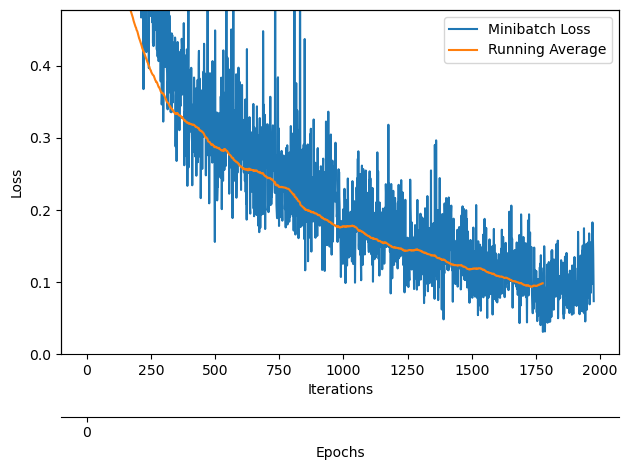

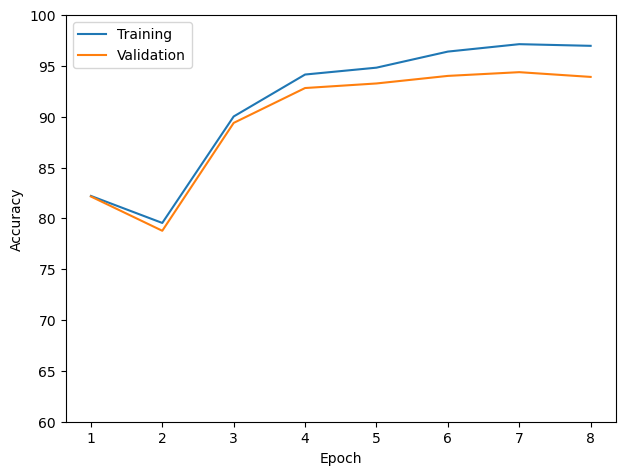

In [15]:
model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=6) # ResNet34

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

## Saving the trained model

In [16]:
torch.save(model.state_dict(), 'resnet_state_dict.pth')
torch.save(model, 'resnet.pth')